In [119]:
import pickle
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

In [21]:
lmbda = 0.01 # change if required
rnd_seed = 4312 # change if required
l_n = []
for n in os.listdir("./results/ID/"):
    l_n.append(re.search(r"(\d+)", n).group())

In [23]:
l_results_dir_ID = []
results_dir = './results/'
results_dir_ID = os.path.join(results_dir, "ID", f'{n}d', str(lmbda), f'seed{rnd_seed:02d}')

In [35]:
all_dirs = []
l_all_results = []

for n in l_n:
    results_dir_ID = f'./results/ID/{n}d/0.01/seed4312/'
    all_dirs.append(results_dir_ID)
for d in all_dirs:
    with open(os.path.join(d, 'results-ID.pkl'), "rb") as f:
        l_results = pickle.load(f)
        l_all_results.append(l_results)

In [196]:
l_eval = []

for id, all_results in enumerate(l_all_results):
    val_acc_avg = np.array([l[1] for l in all_results["l_val_avg"]])
    val_acc_ID = np.array([l[1] for l in all_results["l_val_ID"]])
    n_dim = all_results["l_train_ID"][0]["ics"].shape[0]
    l_n_data_train = []
    l_n_data_eval = []
    for subj in all_results["l_train_ID"]:
        train_accs = np.array(subj["train_accs"])
        df_train = pd.DataFrame({
            "ID": np.arange(0, train_accs.shape[0]),  
            "n_dim": np.repeat(n_dim, train_accs.shape[0]), 
            "epoch": np.arange(0, train_accs.shape[0]),
            "train_acc": train_accs
        })
        l_train.append(df_train)
        l_n_data_train.append(subj["n_choices_train"])
        l_n_data_eval.append(subj["n_choices_test"])
    n_data_train = np.array(l_n_data_train)
    n_data_eval = np.array(l_n_data_eval)
    df_eval = pd.DataFrame({
        "ID": np.arange(0, val_acc_avg.shape[0]),  
        "n_dim": np.repeat(n_dim, val_acc_avg.shape[0]), 
        "val_acc_avg": val_acc_avg, "val_acc_ID": val_acc_ID,
        "n_data_train": n_data_train,
        "n_data_eval": n_data_eval

    })
    l_eval.append(df_eval)

In [201]:
dfs_eval = reduce(lambda left, right: pd.concat([left, right]), l_eval)
dfs_train = reduce(lambda left, right: pd.concat([left, right]), l_train)

In [202]:
dfs_eval["delta"] = dfs_eval["val_acc_ID"] - dfs_eval["val_acc_avg"]
# only required because bug in previous badge > 50
dfs_eval = dfs_eval.query("n_dim <= 50")

,ID,n_dim,val_acc_avg,val_acc_ID,n_data_train,n_data_eval,delta
0,0,10,0.582857,0.592857,2848,712,0.010
1,1,10,0.555000,0.535000,960,240,-0.020
2,2,10,0.570000,0.600000,448,112,0.030
3,3,10,0.585000,0.570000,928,232,-0.015
4,4,10,0.580000,0.560000,672,168,-0.020


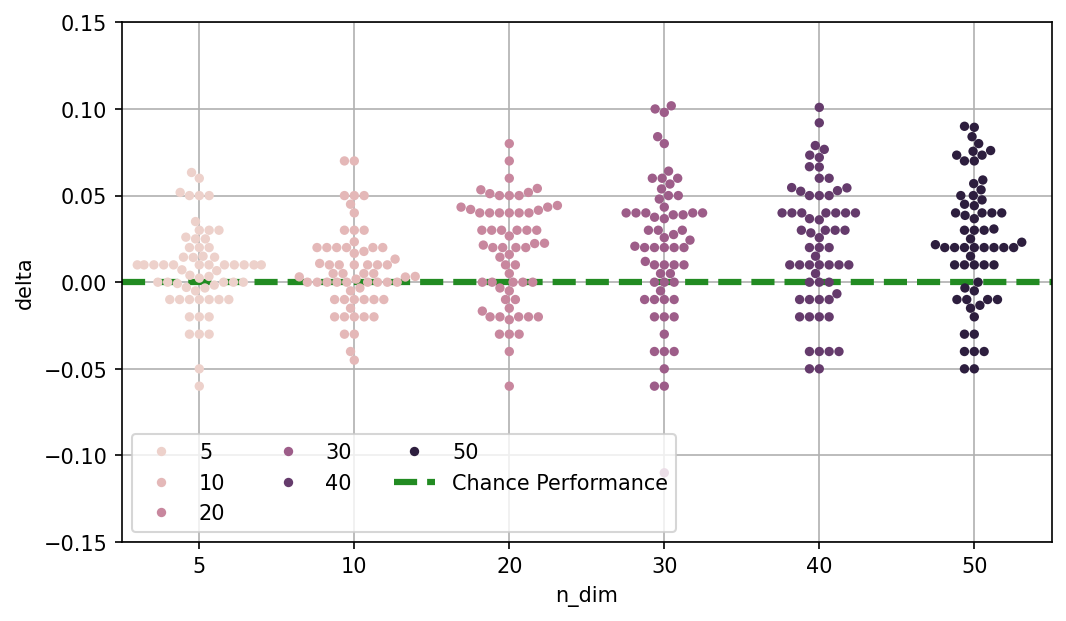

In [204]:
fig = plt.figure(figsize=(8, 4.5), dpi=150)
ax = plt.subplot(111)
sns.swarmplot(
    x="n_dim", y="delta", hue="n_dim", data=dfs_eval.reset_index(drop=True), 
    size=4.5
)
ax.axhline(y=0, color='forestgreen', linestyle='--', linewidth=3, label='Chance Performance')
ax.set_ylim(-.15, .15)
ax.legend(loc=0, ncol = 3)
ax.grid(True)

In [205]:
dfs_eval.loc[:, "n_data_train_log"] = np.log(dfs_eval["n_data_train"])

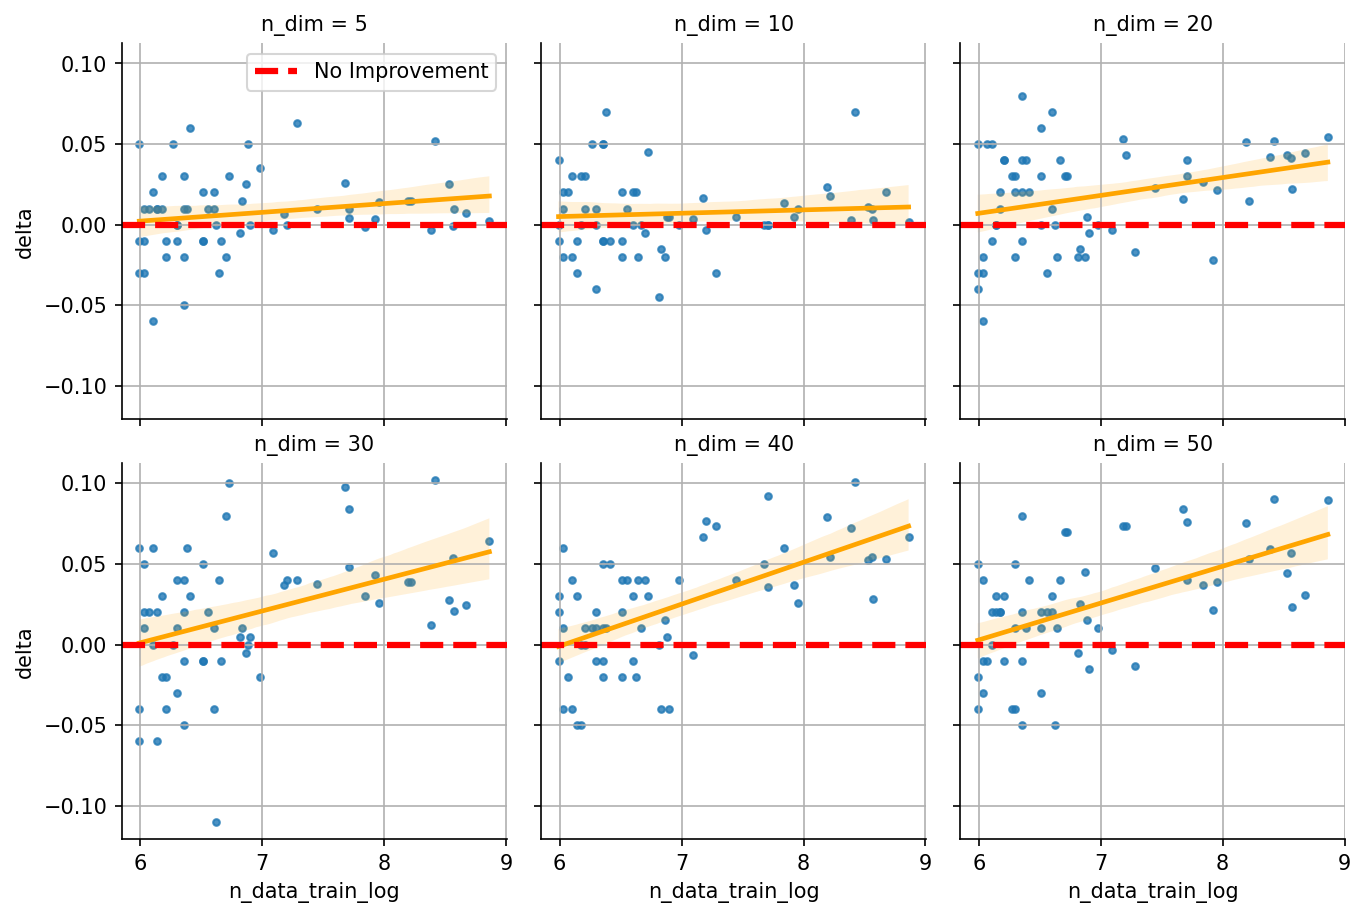

In [208]:
# Create the FacetGrid without specifying an external axis
g = sns.lmplot( data=dfs_eval, x='n_data_train_log', y='delta', col='n_dim', col_wrap=3, height=4, 
               # Adjust height for each facet 
               aspect=1, # Adjust aspect ratio 
               scatter_kws={'s': 10}, # Adjust the scatter plot marker size 
               line_kws={'color': 'orange'} # Adjust the regression line color 
              )
# Add gridlines to each facet 
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=3, label='No Improvement')
    if i == 0:
        ax.legend()
    
# Adjust the plot size
g.fig.set_size_inches(9, 6)
g.fig.set_dpi(150)

plt.show()


In [212]:
dfs_eval.sort_values("n_data_train", ascending=False)

,ID,n_dim,val_acc_avg,val_acc_ID,n_data_train,n_data_eval,delta,n_data_train_log
39,39,40,0.582941,0.649412,7056,1764,0.066471,8.861634
39,39,20,0.592941,0.647059,7056,1764,0.054118,8.861634
39,39,50,0.544706,0.634118,7056,1764,0.089412,8.861634
39,39,10,0.638235,0.640000,7056,1764,0.001765,8.861634
39,39,5,0.619412,0.621765,7056,1764,0.002353,8.861634
...,...,...,...,...,...,...,...,...
43,43,5,NaN,NaN,320,80,NaN,5.768321
44,44,10,NaN,NaN,320,80,NaN,5.768321
43,43,50,NaN,NaN,320,80,NaN,5.768321
44,44,50,NaN,NaN,320,80,NaN,5.768321
